<h1>KNN Exploration</h1>
This notebook will contain Erika's contribution to the assignment. To start with, Erika will look at using KNN on the Kickstarter data. If this proves uninteresting (and as time allows) Erika will also work on applying SVM to similar data.

In [59]:
# Load necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# For KNN stuff
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# For KNN scaling transformation
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn_pandas import DataFrameMapper
from copy import deepcopy

In [60]:
def load_preprocessed_data(name):
    # TODO: as additional preprocessing is completed, add options here.
    if name == 'basic_name':
        x_train = pd.read_csv("data/preprocess-{}-x-train-correct.csv".format(name), index_col=0)
        y_train = pd.read_csv("data/preprocess-{}-y-train-correct.csv".format(name), squeeze=True)
        x_valid = pd.read_csv("data/preprocess-{}-x-valid-correct.csv".format(name), index_col=0)
        y_valid = pd.read_csv("data/preprocess-{}-y-valid-correct.csv".format(name), squeeze=True)
    elif name == 'base' or name == 'doc2vec':
        x_train = pd.read_csv("data/preprocess-{}-x-train.csv".format(name), index_col=0)
        y_train = pd.read_csv("data/preprocess-{}-y-train.csv".format(name), squeeze=True)
        x_valid = pd.read_csv("data/preprocess-{}-x-valid.csv".format(name), index_col=0)
        y_valid = pd.read_csv("data/preprocess-{}-y-valid.csv".format(name), squeeze=True)
    else:
        raise Exception("No preprocessd data available for that name.")
    return x_train, y_train, x_valid, y_valid
        

We want to run all of our algorithms - including KNN, in this notebook - on several different versions of preprocessed data. Load them all here.

In [61]:
x_train_base, y_train_base, x_valid_base, y_valid_base = load_preprocessed_data('base')
x_train_d2v, y_train_d2v, x_valid_d2v, y_valid_d2v = load_preprocessed_data('doc2vec')
x_train_basic, y_train_basic, x_valid_basic, y_valid_basic = load_preprocessed_data('basic_name')
# TODO: load addtional preprocessed data

In [62]:
print(len(x_train_base))
print(len(y_train_base))
x_train_base.head()

249956
249956


,main_category,category,duration,usd_goal_real,launched_month,deadline_month
0,12,19,-0.316333,-0.036515,4.0,5.0
2,8,136,2.025723,-0.031740,10.0,0.0
4,7,44,-0.272265,-0.032463,7.0,8.0
5,5,31,-0.400095,-0.034948,2.0,3.0
6,6,93,-0.326225,0.008140,0.0,2.0


In [63]:
print(len(x_train_d2v))
print(len(y_train_d2v))
x_train_d2v.head()

249956
249956


,main_category,category,duration,usd_goal_real,launched_month,deadline_month,doc2vec_names_0,doc2vec_names_1,doc2vec_names_2,doc2vec_names_3,...,doc2vec_names_10,doc2vec_names_11,doc2vec_names_12,doc2vec_names_13,doc2vec_names_14,doc2vec_names_15,doc2vec_names_16,doc2vec_names_17,doc2vec_names_18,doc2vec_names_19
0,12,19,-0.316333,-0.036515,4.0,5.0,0.009077,-0.029281,-0.014818,-0.017581,...,0.013778,-0.047939,-0.063131,0.015074,-0.003315,-0.072243,0.029401,-0.058894,-0.008851,-0.004987
2,8,136,2.025723,-0.031740,10.0,0.0,-0.015903,0.037791,-0.035279,-0.029695,...,-0.055231,-0.034383,0.003102,0.029496,-0.097409,-0.059037,0.045664,-0.052574,0.034218,0.041212
4,7,44,-0.272265,-0.032463,7.0,8.0,0.018435,0.037622,0.031674,-0.049406,...,-0.048317,0.023729,-0.057103,0.023843,0.044732,-0.049317,-0.029703,-0.100054,0.014423,0.055918
5,5,31,-0.400095,-0.034948,2.0,3.0,0.020175,-0.015965,-0.012979,-0.058172,...,-0.008836,-0.055694,-0.005870,0.016705,-0.025267,0.002448,0.018852,-0.024194,0.007968,0.031140
6,6,93,-0.326225,0.008140,0.0,2.0,0.005605,0.003581,0.019905,-0.063847,...,-0.033168,-0.017154,-0.019477,0.027361,-0.083247,0.006590,-0.020938,-0.052568,-0.026672,0.040495


In [64]:
x_train_basic.head()

,Unnamed: 0.1,main_category,category,duration,usd_goal_real,launched_month_deadline_month_0,launched_month_deadline_month_1,num_chars,num_unusual_words,num_weird_chars
0,0,12,19,-0.316333,-0.036515,4.0,5.0,56,1,2
1,2,8,136,2.025723,-0.031740,10.0,0.0,30,2,0
2,4,7,44,-0.272265,-0.032463,7.0,8.0,60,4,0
3,5,5,31,-0.400095,-0.034948,2.0,3.0,34,3,1
4,6,6,93,-0.326225,0.008140,0.0,2.0,49,2,6


In [65]:
# Had to rename due to a change in preprocessing. The values are the same, just not the column names.x_train_basic.columns = ['index', 'main_category', 'category', 'duration', 'usd_goal_real', 'launched_month', 'deadline_month', 'num_chars', 'num_unusual_words', 'num_weird_chars']
x_train_basic.set_index('Unnamed: 0.1', drop=True, inplace=True)

print(len(x_train_basic))
print(len(y_train_basic))
x_train_basic.head()

249956
249956


,main_category,category,duration,usd_goal_real,launched_month_deadline_month_0,launched_month_deadline_month_1,num_chars,num_unusual_words,num_weird_chars
Unnamed: 0.1,,,,,,,,,
0,12,19,-0.316333,-0.036515,4.0,5.0,56,1,2
2,8,136,2.025723,-0.031740,10.0,0.0,30,2,0
4,7,44,-0.272265,-0.032463,7.0,8.0,60,4,0
5,5,31,-0.400095,-0.034948,2.0,3.0,34,3,1
6,6,93,-0.326225,0.008140,0.0,2.0,49,2,6


In [14]:
y_train_base.head()

0     True
1     True
2    False
3    False
4    False
Name: success, dtype: bool

In [15]:
y_train_d2v.head()

0     True
1     True
2    False
3    False
4    False
Name: success, dtype: bool

In [16]:
y_train_basic.head()

0     True
1     True
2    False
3    False
4    False
Name: 1, dtype: bool

In [66]:
def get_knn_mapper():
    mapper = DataFrameMapper([
        (['launched_month'], MinMaxScaler()),
        (['deadline_month'], MinMaxScaler()),
        (['category'], MinMaxScaler()),
        (['main_category'], MinMaxScaler()),
    ], df_out=True)
    return mapper

def get_knn_basic_mapper():
    mapper = DataFrameMapper([
        (['launched_month_deadline_month_0'], MinMaxScaler()),
        (['launched_month_deadline_month_1'], MinMaxScaler()),
        (['category'], MinMaxScaler()),
        (['main_category'], MinMaxScaler()),
        (['num_chars'], MinMaxScaler()),
        (['num_unusual_words'], MinMaxScaler()),
        (['num_weird_chars'], MinMaxScaler())
    ], df_out=True)
    return mapper

In [67]:
%%time
mapper = get_knn_mapper()
x_train_base_scaled = mapper.fit_transform(x_train_base)
x_valid_base_scaled = mapper.transform(x_valid_base)
x_train_d2v_scaled = mapper.fit_transform(x_train_d2v)
x_valid_d2v_scaled = mapper.transform(x_valid_d2v)

basic_mapper = get_knn_basic_mapper()
x_train_basic_scaled = basic_mapper.fit_transform(x_train_basic)
x_valid_basic_scaled = basic_mapper.transform(x_valid_basic)

CPU times: user 801 ms, sys: 16.5 ms, total: 818 ms
Wall time: 107 ms


In [68]:
x_train_basic_scaled.head()

,launched_month_deadline_month_0,launched_month_deadline_month_1,category,main_category,num_chars,num_unusual_words,num_weird_chars
Unnamed: 0.1,,,,,,,
0,0.363636,0.454545,0.120253,0.857143,0.597826,0.111111,0.037037
2,0.909091,0.000000,0.860759,0.571429,0.315217,0.222222,0.000000
4,0.636364,0.727273,0.278481,0.500000,0.641304,0.444444,0.000000
5,0.181818,0.272727,0.196203,0.357143,0.358696,0.333333,0.018519
6,0.000000,0.181818,0.588608,0.428571,0.521739,0.222222,0.111111


In [69]:
# Start by looking at scikit learn nearest neightbors
def try_knn(x_train, y_train, x_valid, y_valid, neighbors, weights, algorithm='auto'):
    knn = KNeighborsClassifier(n_neighbors=neighbors, weights=weights, algorithm=algorithm, n_jobs=8)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_valid)
    return knn, metrics.accuracy_score(y_valid, y_pred)

In [70]:
def get_scores(n_low, n_high, n_step, x_train, y_train, x_valid, y_valid, weights=['uniform', 'distance']):
    print("Calling 'get_scores'")
    max_score = (0, None, None, None)
    scores = {}
    for w in weights:
        print("Looking at weight measurement: {}".format(w))
        scores["{}".format(w)] = []
        for n in range(n_low, n_high + 1, n_step):
            knn, score = try_knn(x_train, y_train, x_valid, y_valid, neighbors=n, weights=w)
            if (n % 5 == 0):
                print("\tFor {: 3} neighbors, score: {}".format(n, score))
            scores["{}".format(w)].append((n, score))
            if max_score[0] < score:
                max_score = (score, w, n, knn)
    return max_score, scores

In [71]:
def plot_scores(scores):
    fig, ax = plt.subplots()
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'black']

    for i, (key, score_array) in enumerate(scores.items()):
        ns = [n for (n, _) in score_array]
        ss = [s for (_, s) in score_array]
        line, = ax.plot(ns, ss, color=colors[i])
        line.set_label(key)
    
    # Label axes
    ax.set(xlabel='Number of neighbors', ylabel='Score',
           title='A graph plotting number of neighbors and scores')

    ax.legend()
    plt.show()

<h3>Parameter Tuning and Scaling Checks</h3>
The below runs are to start tuning the numbers of neighbors, and also check to see if the MinMaxScaling was effective at all in increasing accuracy.

Calling 'get_scores'
Looking at weight measurement: uniform
	For  25 neighbors, score: 0.6394778790339559
	For  50 neighbors, score: 0.6436283798008963
	For  75 neighbors, score: 0.6398989443291527
	For  100 neighbors, score: 0.6405305422719481
	For  125 neighbors, score: 0.6399590965141809
	For  150 neighbors, score: 0.6385455201660201
	For  175 neighbors, score: 0.6379139222232247
	For  200 neighbors, score: 0.637522933020542
	For  225 neighbors, score: 0.6361394327648952
	For  250 neighbors, score: 0.6361394327648952
	For  275 neighbors, score: 0.6361995849499233
	For  300 neighbors, score: 0.6368913350777466
	For  325 neighbors, score: 0.6371018677253452
	For  350 neighbors, score: 0.6367409546151764
	For  375 neighbors, score: 0.6361995849499233
	For  400 neighbors, score: 0.636049204487353
	For  425 neighbors, score: 0.6345754759541641
	For  450 neighbors, score: 0.6336731931787423
	For  475 neighbors, score: 0.6335829649012
	For  500 neighbors, score: 0.6342446389365094
	For  52

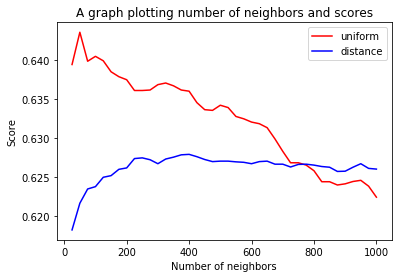

CPU times: user 36min 53s, sys: 4min 12s, total: 41min 6s
Wall time: 5min 35s


In [41]:
%%time
num_samples = 50000
max_score_base, scores_base = get_scores(25, 1000, 25, 
                                         x_train_base.head(num_samples), 
                                         y_train_base.head(num_samples), 
                                         x_valid_base.head(num_samples), 
                                         y_valid_base.head(num_samples))
print("The max score is: {} (w={}, n={})".format(max_score_base[0], max_score_base[1], max_score_base[2]))
plot_scores(scores_base)

Calling 'get_scores'
Looking at weight measurement: uniform
	For  25 neighbors, score: 0.6318385515353845
	For  50 neighbors, score: 0.6342446389365094
	For  75 neighbors, score: 0.6313272579626454
	For  100 neighbors, score: 0.6272669854732473
	For  125 neighbors, score: 0.6230864086137929
	For  150 neighbors, score: 0.6213419952479774
	For  175 neighbors, score: 0.6199584949923306
	For  200 neighbors, score: 0.6169809618334386
	For  225 neighbors, score: 0.6112665042557671
	For  250 neighbors, score: 0.6134921351018076
	For  275 neighbors, score: 0.611747721735992
	For  300 neighbors, score: 0.6132515263616951
	For  325 neighbors, score: 0.6110258955156546
	For  350 neighbors, score: 0.6080784384492767
	For  375 neighbors, score: 0.6099431561851484
	For  400 neighbors, score: 0.6088904929471564
	For  425 neighbors, score: 0.6101236127402327
	For  450 neighbors, score: 0.6103942975728593
	For  475 neighbors, score: 0.6100333844626906
	For  500 neighbors, score: 0.6092514060573251
	For

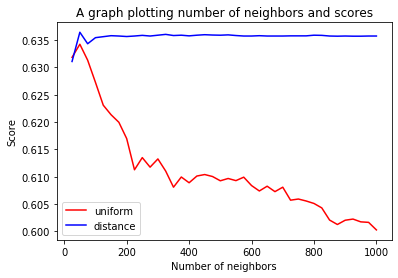

CPU times: user 30min 43s, sys: 3min 57s, total: 34min 41s
Wall time: 4min 51s


In [42]:
%%time
num_samples = 50000
max_score_base_scaled, scores_base_scaled = get_scores(25, 1000, 25, 
                                         x_train_base_scaled.head(num_samples), 
                                         y_train_base.head(num_samples), 
                                         x_valid_base_scaled.head(num_samples), 
                                         y_valid_base.head(num_samples))
print("The max score is: {} (w={}, n={})".format(max_score_base[0], max_score_base[1], max_score_base[2]))
plot_scores(scores_base_scaled)

<h3> Initial Results </h3>
MinMaxScaling appears to boost accuracy just a bit. Now that I've narrowed down a likely range for good values for neighbors, I'll do a more fine-grained search with all of the data. I've also seen that distance seems to work best, so I'll start only considering distance weights.

Calling 'get_scores'
Looking at weight measurement: distance
	For  60 neighbors, score: 0.6450118800565431
	For  65 neighbors, score: 0.6446208908538603
	For  70 neighbors, score: 0.6437787602634666
	For  75 neighbors, score: 0.6430268579506151
	For  80 neighbors, score: 0.643989292911065
	For  85 neighbors, score: 0.6438088363559806
	For  90 neighbors, score: 0.6447111191314024
	For  95 neighbors, score: 0.6451321844265993
	For  100 neighbors, score: 0.6457337062768805
	For  105 neighbors, score: 0.6454329453517399
	For  110 neighbors, score: 0.6457337062768805
	For  115 neighbors, score: 0.6458540106469367
	For  120 neighbors, score: 0.6462449998496196
	For  125 neighbors, score: 0.6462149237571054
	For  130 neighbors, score: 0.6463352281271617
	For  135 neighbors, score: 0.6461848476645914
	For  140 neighbors, score: 0.645974315016993
	For  145 neighbors, score: 0.6456735540918523
	For  150 neighbors, score: 0.6457637823693946
	For  155 neighbors, score: 0.6461547715720773
	For  160

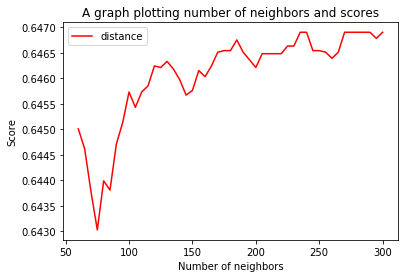

CPU times: user 13min 3s, sys: 2min 26s, total: 15min 29s
Wall time: 2min 32s


In [43]:
%%time
max_score_base, scores_base = get_scores(60, 300, 5, 
                                         x_train_base_scaled, 
                                         y_train_base, 
                                         x_valid_base_scaled, 
                                         y_valid_base,
                                        weights=['distance'])
print("The max score is: {} (w={}, n={})".format(max_score_base[0], max_score_base[1], max_score_base[2]))
plot_scores(scores_base)

Based on this initial result, the best score I'm seeing is:

The max score is: 0.6469066738849288 (w=distance, n=235)

Now, let's see if we can do better with the doc2vec preprocessed data.

Calling 'get_scores'
Looking at weight measurement: distance
	For  60 neighbors, score: 0.6450118800565431
	For  65 neighbors, score: 0.6446208908538603
	For  70 neighbors, score: 0.6437787602634666
	For  75 neighbors, score: 0.6430268579506151
	For  80 neighbors, score: 0.643989292911065
	For  85 neighbors, score: 0.6438088363559806
	For  90 neighbors, score: 0.6447111191314024
	For  95 neighbors, score: 0.6451321844265993
	For  100 neighbors, score: 0.6457337062768805
	For  105 neighbors, score: 0.6454329453517399
	For  110 neighbors, score: 0.6457337062768805
	For  115 neighbors, score: 0.6458540106469367
	For  120 neighbors, score: 0.6462449998496196
	For  125 neighbors, score: 0.6462149237571054
	For  130 neighbors, score: 0.6463352281271617
	For  135 neighbors, score: 0.6461848476645914
	For  140 neighbors, score: 0.645974315016993
	For  145 neighbors, score: 0.6456735540918523
	For  150 neighbors, score: 0.6457637823693946
	For  155 neighbors, score: 0.6461547715720773
	For  160

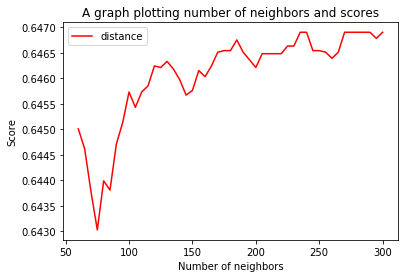

CPU times: user 13min 11s, sys: 2min 22s, total: 15min 34s
Wall time: 2min 31s


In [73]:
%%time
max_score_d2v, scores_d2v = get_scores(60, 300, 5, 
                                         x_train_d2v_scaled, 
                                         y_train_d2v, 
                                         x_valid_d2v_scaled, 
                                         y_valid_d2v,
                                        weights=['distance'])
print("The max score is: {} (w={}, n={})".format(max_score_d2v[0], max_score_d2v[1], max_score_d2v[2]))
plot_scores(scores_d2v)

Based on this initial result, the best score I'm seeing is:

The max score is: 0.6469066738849288 (w=distance, n=235)

Now, let's see if we can do better with the basic name preprocessed data.

Calling 'get_scores'
Looking at weight measurement: distance
	For  60 neighbors, score: 0.6168907335558964
	For  65 neighbors, score: 0.6175524075912058
	For  70 neighbors, score: 0.6178230924238323
	For  75 neighbors, score: 0.618214081626515
	For  80 neighbors, score: 0.6188757556618244
	For  85 neighbors, score: 0.6185749947366838
	For  90 neighbors, score: 0.6187855273842823
	For  95 neighbors, score: 0.6184546903666276
	For  100 neighbors, score: 0.6185148425516557
	For  105 neighbors, score: 0.6185148425516557
	For  110 neighbors, score: 0.6190261361243947
	For  115 neighbors, score: 0.6195975818821619
	For  120 neighbors, score: 0.6192065926794791
	For  125 neighbors, score: 0.6189960600318807
	For  130 neighbors, score: 0.6195975818821619
	For  135 neighbors, score: 0.619146440494451
	For  140 neighbors, score: 0.6205600168426119
	For  145 neighbors, score: 0.6208006255827243
	For  150 neighbors, score: 0.6197479623447322
	For  155 neighbors, score: 0.6200186471773588
	For  160

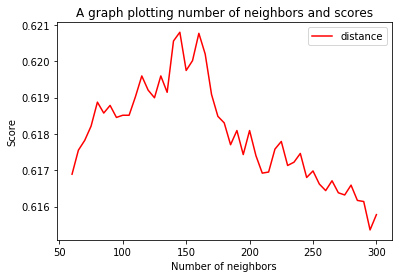

CPU times: user 20min 23s, sys: 2min 9s, total: 22min 33s
Wall time: 3min 47s


In [72]:
%%time
max_score_basic, scores_basic = get_scores(60, 300, 5, 
                                         x_train_basic_scaled, 
                                         y_train_basic, 
                                         x_valid_basic_scaled, 
                                         y_valid_basic,
                                        weights=['distance'])
print("The max score is: {} (w={}, n={})".format(max_score_basic[0], max_score_basic[1], max_score_basic[2]))
plot_scores(scores_basic)

Based on this initial result, the best score I'm seeing is:

The max score is: 0.6208006255827243 (w=distance, n=145)

In [74]:
def one_hot_df(df, one_hot_cols, drop_cols):
    dfret=deepcopy(df)
    dfret.astype({'launched_month': 'int32'})
    dfret=pd.get_dummies(dfret,columns=one_hot_cols).drop(columns=drop_cols)
    return dfret

one_hot_cols=['main_category','launched_month','deadline_month']
drop_cols=['category']

x_train_base_ohe=one_hot_df(x_train_base, one_hot_cols, drop_cols)
x_valid_base_ohe=one_hot_df(x_valid_base, one_hot_cols, drop_cols)

In [75]:
x_train_base_ohe.head()

,duration,usd_goal_real,main_category_0,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,...,deadline_month_2.0,deadline_month_3.0,deadline_month_4.0,deadline_month_5.0,deadline_month_6.0,deadline_month_7.0,deadline_month_8.0,deadline_month_9.0,deadline_month_10.0,deadline_month_11.0
0,-0.316333,-0.036515,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,2.025723,-0.031740,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.272265,-0.032463,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
5,-0.400095,-0.034948,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
6,-0.326225,0.008140,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


Calling 'get_scores'
Looking at weight measurement: distance
	For  60 neighbors, score: 0.6308460404824205
	For  65 neighbors, score: 0.6321693885530392
	For  70 neighbors, score: 0.6319889319979548
	For  75 neighbors, score: 0.6323498451081235
	For  80 neighbors, score: 0.6326806821257782
	For  85 neighbors, score: 0.6328009864958345
	For  90 neighbors, score: 0.6333122800685735
	For  95 neighbors, score: 0.6332822039760594
	For  100 neighbors, score: 0.6332822039760594
	For  105 neighbors, score: 0.6334025083461157
	For  110 neighbors, score: 0.6332220517910313
	For  115 neighbors, score: 0.6334025083461157
	For  120 neighbors, score: 0.6333122800685735
	For  125 neighbors, score: 0.6336130409937141
	For  130 neighbors, score: 0.6334626605311438
	For  135 neighbors, score: 0.6339138019188547
	For  140 neighbors, score: 0.6342747150290234
	For  145 neighbors, score: 0.6337032692712563
	For  150 neighbors, score: 0.6338536497338266
	For  155 neighbors, score: 0.6341243345664531
	For  1

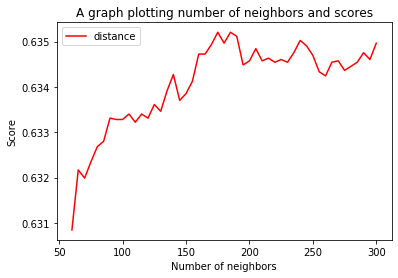

CPU times: user 7h 58min 45s, sys: 3min 34s, total: 8h 2min 19s
Wall time: 1h 8min 38s


In [76]:
%%time
max_score_base, scores_base = get_scores(60, 300, 5, 
                                         x_train_base_ohe, 
                                         y_train_base, 
                                         x_valid_base_ohe, 
                                         y_valid_base,
                                        weights=['distance'])
print("The max score is: {} (w={}, n={})".format(max_score_base[0], max_score_base[1], max_score_base[2]))
plot_scores(scores_base)

Based on this initial result, the best score I'm seeing is:

The max score is: 0.6352070738969593 (w=distance, n=175)